# Time-Dependent Poisson Regression

In [44]:
import numpy as np
from numpy.linalg import inv
from numpy import sqrt, sin, cos, pi, exp, e, log
import scipy.special
import matplotlib.pyplot as plt

## Simulation

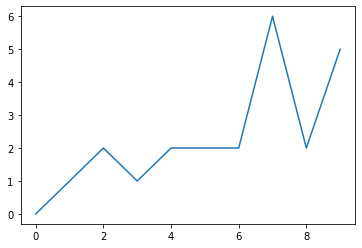

In [134]:
# parameter
alpha = 0.2
beta = 0.55

# time
N = 10
t = np.arange(0,N,1)

# frequency simulation

np.random.seed(20230319)
y = np.random.poisson(lam=alpha+beta*t, size=(N,))

plt.plot(y)
plt.show()


In [135]:
alpha+beta*np.median(t)

2.6750000000000003

In [139]:
# Define loglikelihood function

def loglikelihood(param):
    t_h = np.median(t)
    a, b = param[0], param[1]
    trend = a+b*(t-t_h)
    likelihood = (-np.log(scipy.special.factorial(y)) + y*np.log(trend) - trend).sum()
    return likelihood

## MLE Estimation using Spiral Optimization Algorithm (SOA)

In [140]:
def rotate_in_n_dim(points, theta):
    n = points.shape[1]
    R = np.array([[cos(theta), -sin(theta)],
                  [sin(theta), cos(theta)]])
    points_new = np.array(points)
    
    for i in range(n-1):
        for j in range(i+1,n):
            points_new[:,[i,j]] = points_new[:,[i,j]]@R.T
            
    return points_new


def is_In_Area(point, feasible_area):
    is_In = True
    
    for i, val in enumerate(point):
        if val <= feasible_area[0,i] or val >= feasible_area[1,i]:
            is_In = False
            break
        
    return is_In


feasible_area = np.array([[-20, -20],
                          [20, 20]])
dim = feasible_area.shape[1]
transform_matrix = np.diag([feasible_area[1,j]-feasible_area[0,j] for j in range(dim)])
M = 1000
theta = pi/4
r = 0.95
maxiter = 100

trial = 5
x_center_list = np.zeros((trial,dim))

seed = 20230324 #ke-1

for i in range(0,trial):
    np.random.seed(seed+i)
    points_normalized = np.random.uniform(size=(M,dim))
    points_original = points_normalized@transform_matrix + feasible_area[0]
    values = np.array([-loglikelihood(point) for point in points_original])
    x_center_normalized = points_normalized[np.nanargmin(values)] 

    for k in range(maxiter):
        points_new_normalized = r*rotate_in_n_dim(points_normalized-x_center_normalized, theta) + x_center_normalized
        points_new_original = points_new_normalized@transform_matrix + feasible_area[0]
        values_new = np.array([-loglikelihood(points_new_original[i]) if is_In_Area(points_new_original[i], feasible_area) else float('inf') for i in range(M)])
        points_normalized = points_new_normalized
        values = values_new
        x_center_normalized = points_normalized[np.nanargmin(values)]
        
    x_center_list[i] = np.array([(feasible_area[1,j]-feasible_area[0,j])*x_center_normalized[j]+feasible_area[0,j] for j in range(dim)]).reshape(-1,)
    
    print("Trial ", i+1)
    print(x_center_list[i])
    print("Loglikelihood: ", likelihood(x_center_list[i]))

<ipython-input-139-638ed118ac27>:7: RuntimeWarning: invalid value encountered in log
  likelihood = (-np.log(scipy.special.factorial(y)) + y*np.log(trend) - trend).sum()


Trial  1
[2.30166997 0.49530454]
Loglikelihood:  -14.380822983739389
Trial  2
[2.29995242 0.4952459 ]
Loglikelihood:  -14.380818563088239
Trial  3
[2.30414272 0.49533669]
Loglikelihood:  -14.380863714794291
Trial  4
[2.29813604 0.49482636]
Loglikelihood:  -14.380825723604147
Trial  5
[2.30087862 0.4955027 ]
Loglikelihood:  -14.380821173522374


Even for sampling size of $10$, the MLE estimator (obtained using SOA) is reasonably close to the actual values $a = \alpha + \beta\cdot t_{\text{median}} = 2.675$, $b = \beta = 0.55$.